# Homework 2
**Total Points: 5**

**Instructions:**
1. Complete parts 1 through 5, filling in code or responses where marked with `# YOUR CODE HERE` or `# YOUR RESPONSE HERE`.
2. Do not import additional libraries or move `import` commands.
3. When finished, run the full notebook by selecting <b>Kernel > Restart & Run All</b>. </li>
4. Submit this completed notebook file to <b>NYU Classes</b>. </li>

**Grading:** Each part is worth 1 point.

------------
###  Part 1: Sine Sweep

Write a function `sine_sweep()` that generates a sine sweep using the following equation: 
$$x(t) = a \cdot \sin\left(\text{cumsum}\left( \frac{2\pi f}{f_s} \right)\right)$$
where $a$ is the amplitude, $f_s$ is the sampling frequency and $f$ is a vector of logarithmically spaced frequency values. You may find it useful to use `np.cumsum()` and `np.logspace()`.

In [1]:
import numpy as np

In [2]:
def sine_sweep(f_min, f_max, fs, duration, amplitude):
   
    """ Generate a sine sweep.

    Parameters
    ----------
    f_min: float
        minimum frequency (Hz)
    f_max: float
        maximum frequency (Hz)
    fs: int
        sample rate (samples per second)
    duration: float
        length of the signal (seconds)
    amplitude: float
        amplitude
    
    Returns
    -------
    x: np.array
        sine sweep
    """
    # Creating a logarithmically spaced frequency values
    f = np.geomspace(f_min, f_max, int(duration * fs))
    
    return amplitude * np.sin(np.cumsum(2 * np.pi * f / fs))


### Part 2: Discrete Fourier Transform
Create a function `my_dft()` that calculates the Discrete Fourier Transform of an audio signal using the following equation:
$$X[k] = \sum_{n=0}^{N-1} x[n]\cdot e^{-i 2\pi k n / N}$$
where $N$ is the total number of samples in the input. The output should be a complex-valued numpy array of equal length to the input array.

In [3]:
def my_dft(x):
   
    """ Calculate the Discrete Fourier Transform of an audio signal

    Parameters
    ----------
    x: np.array
        audio samples
    
    Returns
    -------
    dft: np.array
        DFT of samples (complex-valued)
    """
    # For this, I will build a orthogonal matrix that is composed of e**(-1j*2*np.pi*k) vectors
    N = len(x)
    n = np.arange(0, N, 1).reshape((-1, 1))
    k = np.arange(0, N, 1).reshape((1, -1))
    E = np.exp(-1j * 2 * np.pi * (n @ k) / N)
    return x @ E

### Part 3: Plot DFT Frequencies
Create a function `plot_dft()` that plots the frequencies of an audio signal. The function should use `matplotlib.pyplot` to display a plot with the frequencies (Hz) om the X axis and the magnitude on the Y axis. Use the function you created in Part 2 to obtain the DFT of the input audio. Each axis should be labeled and scaled correctly. Remember to account for the DFT redundancy, and to plot the magnitudes of the complex numbers. Do not use librosa.

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,7)

In [5]:
def plot_dft(x, fs):
   
    """ Plot the frequencies and magnitudes of an audio signal

    Parameters
    ----------
    x: np.array
        audio samples
    
    fs: int
        sample rate
    
    Returns
    -------
    none
    
    """
    N = len(x)
    X = my_dft(x)
    X = np.abs(X)
    f = np.linspace(0, fs, N)
    plt.xlabel('Frequency (Hz)', fontsize = 15)
    plt.ylabel('Magnitude', fontsize = 15)
    plt.xlim(0, fs/2)
    plt.grid(b = True)
    return plt.plot(f, X)

### Intermission: Test Your Code
Use the following code to test your functions from Parts 1 - 3. A sine sweep is generated and an audio player is set. Then, two positions in the sine sweep are plotted (on the same figure); one from the beginning of the signal (around 500 Hz), and one from the end (around 5000 Hz). The plot should show clear vertical peaks at these frequencies.

In [6]:
import IPython.display as ipd

In [7]:
fs = 44100
f_min = 500
f_max = 5000
duration = 1.
amplitude = .95

x_sweep = sine_sweep(f_min=f_min, f_max=f_max, fs=fs, duration=duration, amplitude=amplitude)

ipd.Audio(x_sweep, rate=fs)

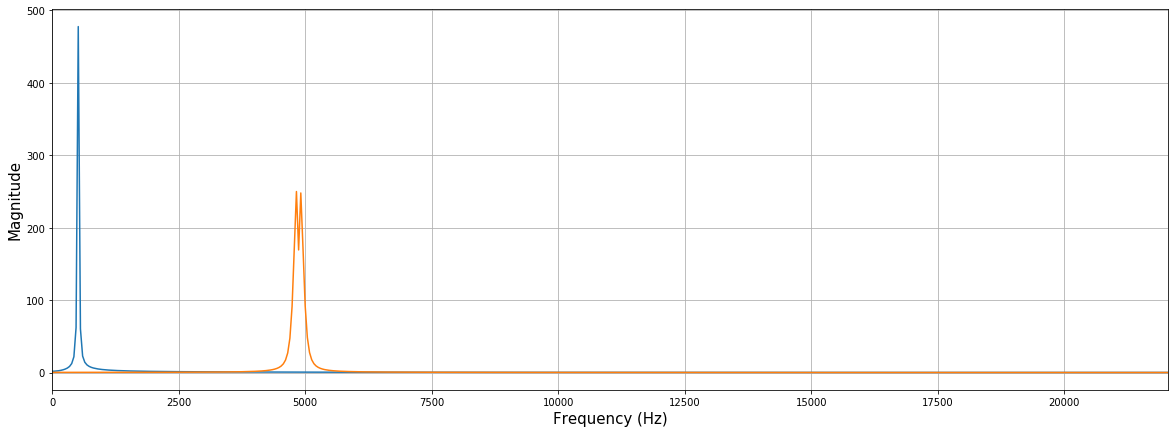

In [8]:
plt.figure()
plot_dft(x_sweep[0:1024],fs=fs)
plot_dft(x_sweep[44100-1024:44100],fs=fs)
plt.show()

### Part 4: Spectrogram
Write a function `plot_spectrogram()` that calculates and plots the spectrogram of a time-domain audio signal.
The plot should have the following features:
- the spectrogram should have the point (0, 0) at the bottom left corner of the plot
- the spectrogram's magnitude values should be scaled to dB
- the x-axis should label time in seconds
- the y-axis should label frequency in Hz
- the z-axis should be labeled using a colorbar

You may use `librosa.stft()`, `librosa.fft_freqs()`, and/or `librosa.frames_to_time()`. Use `plt.imshow()` to display the spectrogram. *Do not use `librosa.display.specshow()`.*

In [9]:
import librosa

# I'm importing the following to build the stft matrix... Comparisons with Librosa are in the next section
from librosa.util.utils import pad_center   
from scipy.signal import get_window
from scipy.fftpack import fft

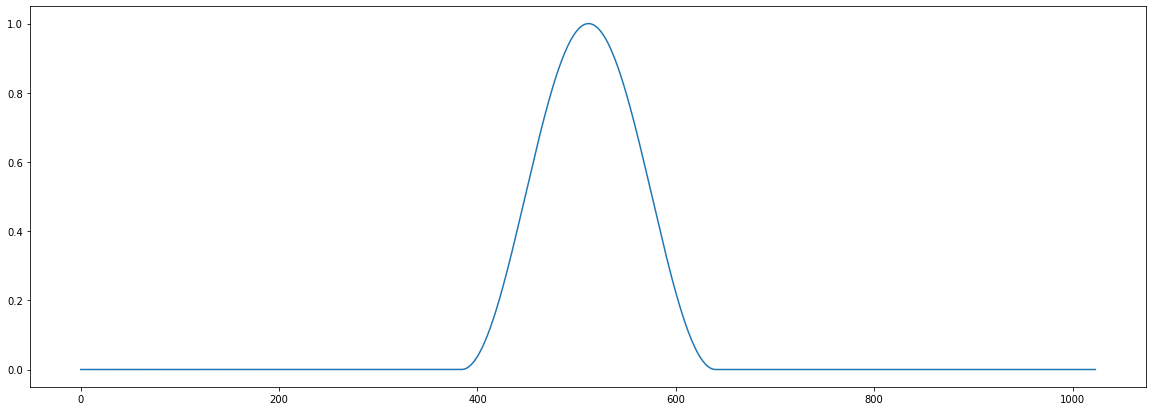

In [10]:
w = get_window('hann', 256)
w = pad_center(w, 1024)
plt.plot(w)

In [11]:
def plot_spectrogram(x, window_size, hop_size, window_type, fs, nfft):
    
    """Calculate and plot the spectrogram of a time-domain audio signal.

    Parameters
    ----------
    x : np.array
        time domain signal
    window_size : int
        window size (in samples)
    hop_size : int
        hop size (in samples)
    window_type : str
        window type (one of "boxcar" (rectangular), "triang", or "hann")
    fs : int
        sample rate (samples per second)
    nfft : int
        fft length (in samples)

    Returns
    -------
    None
    """
    x = x.copy()
    # set window
    w = get_window(window_type, window_size)
    # designate an stft array to catch the computed magnitudes. 
    stft_array = []
    end = len(x) - len(w)                                          # setting an end point for iteration
    start = 0
    # slice, window, and perform fft on the frames of x 
    while start <= end:
        x_frame = x[start : start + w.size]                        # cutting the frame to window size
        x_frame *= w                                               # windowing the frame
        x_frame = pad_center(x_frame, nfft)                        # pad the fft_frame
        X = np.abs(fft(x_frame)[:(nfft // 2) + 1])                   # perform fft on the frame cropped, select 1st half
        X = 20 * np.log10(X)                                       # taking the log of the magnitude for dB scaling
        stft_array.append(X)                                       # appending the fft result to the master array
        start += hop_size
    stft = np.array(stft_array).T                                  # setting stft array to a numpy matrix
    print(stft.shape)
    t = np.linspace(0, len(x)/fs, stft.shape[1])                   # normalizing the time axis for plotting
    f = np.linspace(0, fs/2, stft.shape[0])                        # normalizing the frequency axis for plotting
    plt.xlabel('Time (s)', fontsize = 15)
    plt.ylabel('Frequency (Hz)', fontsize = 15)
    plt.ylim(0, 5500)
    plot = plt.pcolormesh(t, f, stft)   # I find it easier to normalize the axis with pcolormesh vs. imshow
    return plot

------------
### Part 5: Analysis 
Explore how different parameter choices affect the spectrogram of a sine sweep. For each of the following variations:

- run `plot_spectrogram()`
- discuss what happens as you introduce each variation
- discuss why these effects occur

Unless otherwise stated, `N=128`, and for a window size `N`, use a hop size of `N/2`, a rectangular window, an fft length of `N`.


**A. Default parameters as above**

***(ALSO: A a quick comparison between `librosa.stft` and `My STFT`. I cut the the y-axis at 5500 Hz so we can see better!)***

(65, 690)
(65, 688)


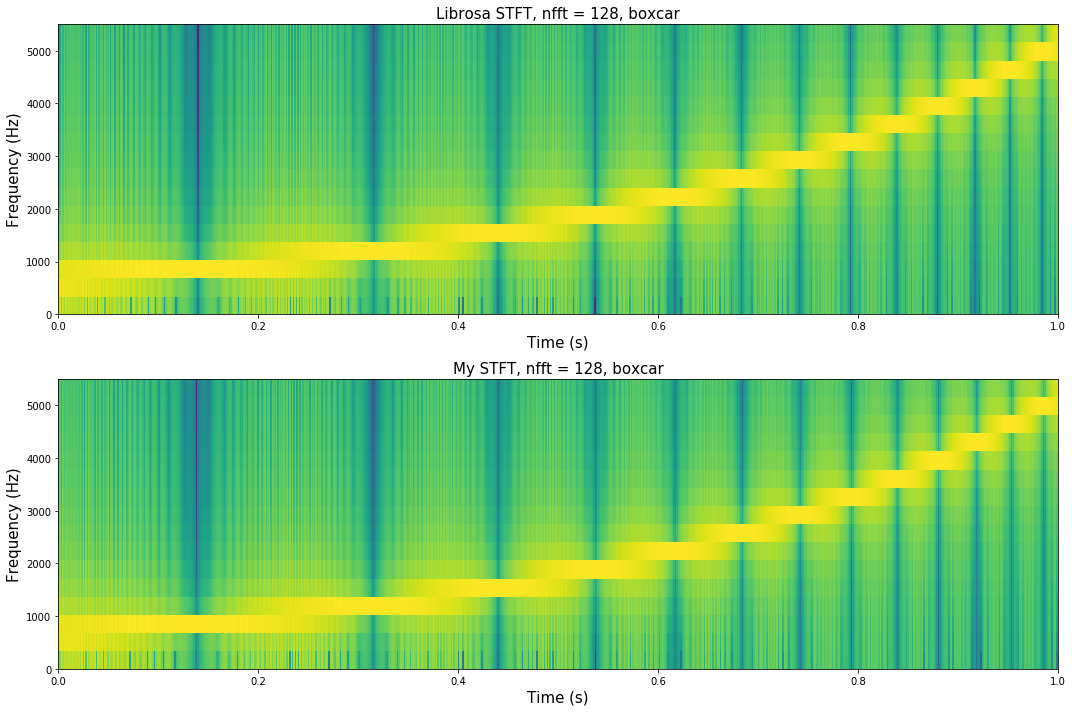

In [12]:
# Librosa's function
plt.figure(figsize=(15, 10))
N = 128
X = librosa.core.stft(x_sweep, n_fft=N, hop_length=N//2, win_length=N, window='boxcar')
print(X.shape)
X = np.abs(X)
X = 10 * np.log10(X)
t = np.linspace(0, len(x_sweep)/fs, X.shape[1])                  
f = np.linspace(0, fs/2, X.shape[0]) 
plt.subplot(211)
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Frequency (Hz)', fontsize = 15)
plt.ylim(0, 5500)
plt.title('Librosa STFT, nfft = 128, boxcar', fontsize = 15)
plt.pcolormesh(t, f, X)


# My function
plt.subplot(212)
plt.title('My STFT, nfft = 128, boxcar', fontsize = 15)
plot_spectrogram(x_sweep, window_size = N, hop_size = N//2, window_type = 'boxcar', fs = 44100, nfft = N)
plt.tight_layout()

`The nfft size is quite small (128). From the spectral leakage we can see the time resolution is very high. However the frequency resolution suffers as each frequency bin is appx. 44100/128 = 344 (Hz)`

**B. window size `N=256`, `N=512`, and `N=1024`**

(129, 343)
(257, 171)
(513, 85)


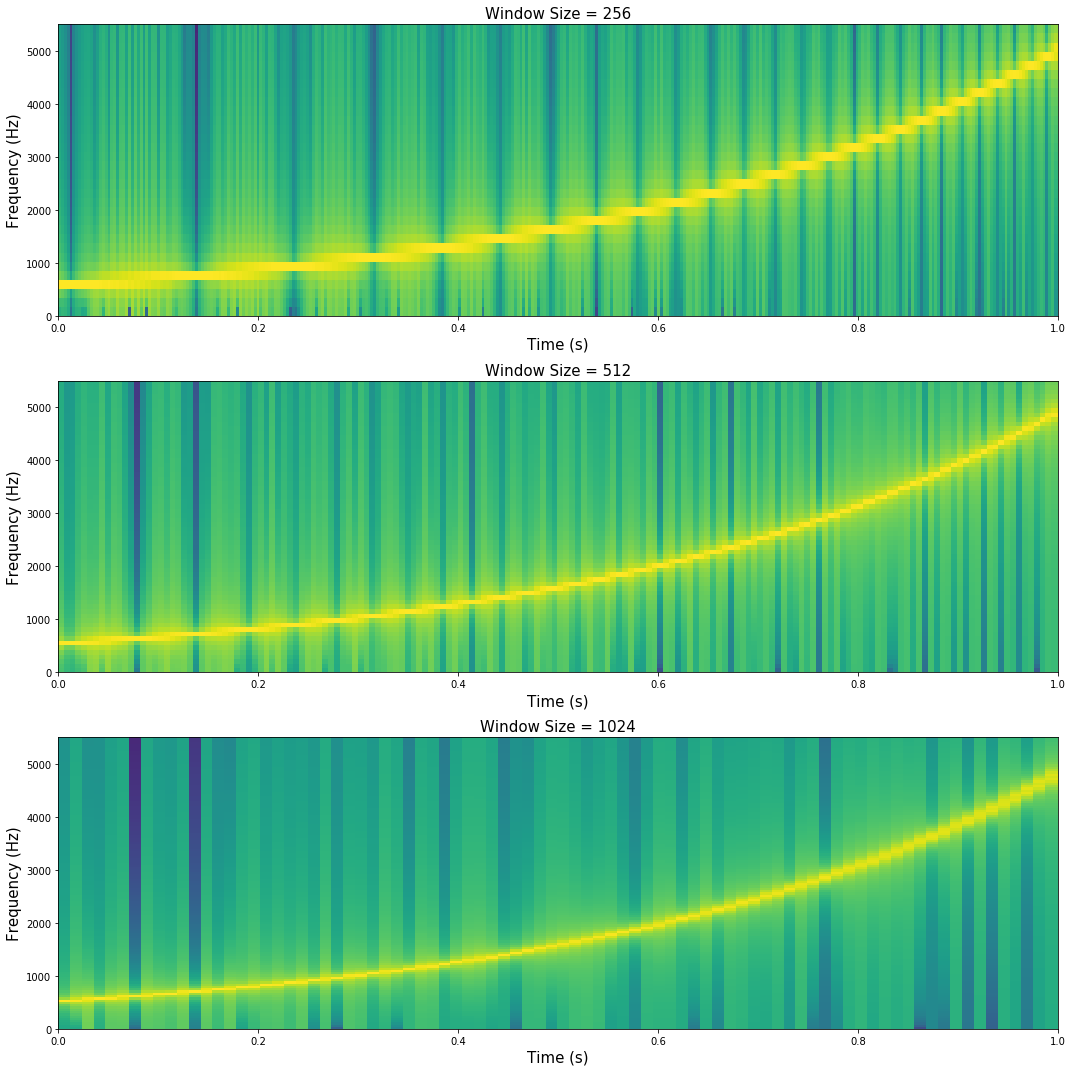

In [13]:
N = 256
plt.rcParams['figure.figsize'] = (15, 15)
plt.subplot(311)
plt.title('Window Size = {}'.format(N), fontsize = 15)
B1 = plot_spectrogram(x_sweep, window_size = N, hop_size = N // 2, window_type = 'boxcar', fs = 44100, nfft = N)
plt.subplot(312)
plt.title('Window Size = {}'.format(2 * N), fontsize = 15)
B2 = plot_spectrogram(x_sweep, window_size = 2 * N, hop_size = N, window_type = 'boxcar', fs = 44100, nfft = 2*N)
plt.subplot(313)
plt.title('Window Size = {}'.format(4 * N), fontsize = 15)
B3 = plot_spectrogram(x_sweep, window_size = 4 * N, hop_size = 2 * N, window_type = 'boxcar', fs = 44100, nfft = 4*N)
plt.tight_layout()


`As we increase the window size, we get better frequency resolution, at the expense of time resolution. This is because as window size increases, frequency bin size decreases (better freq domain resolution), however, we need more time domain samples for each window, thus increasing the time intervals per fft slice.`

**C. window size `N=256` with hop size `N/4`, `N/16`, and `N/32`**

(129, 686)
(129, 2741)
(129, 5481)


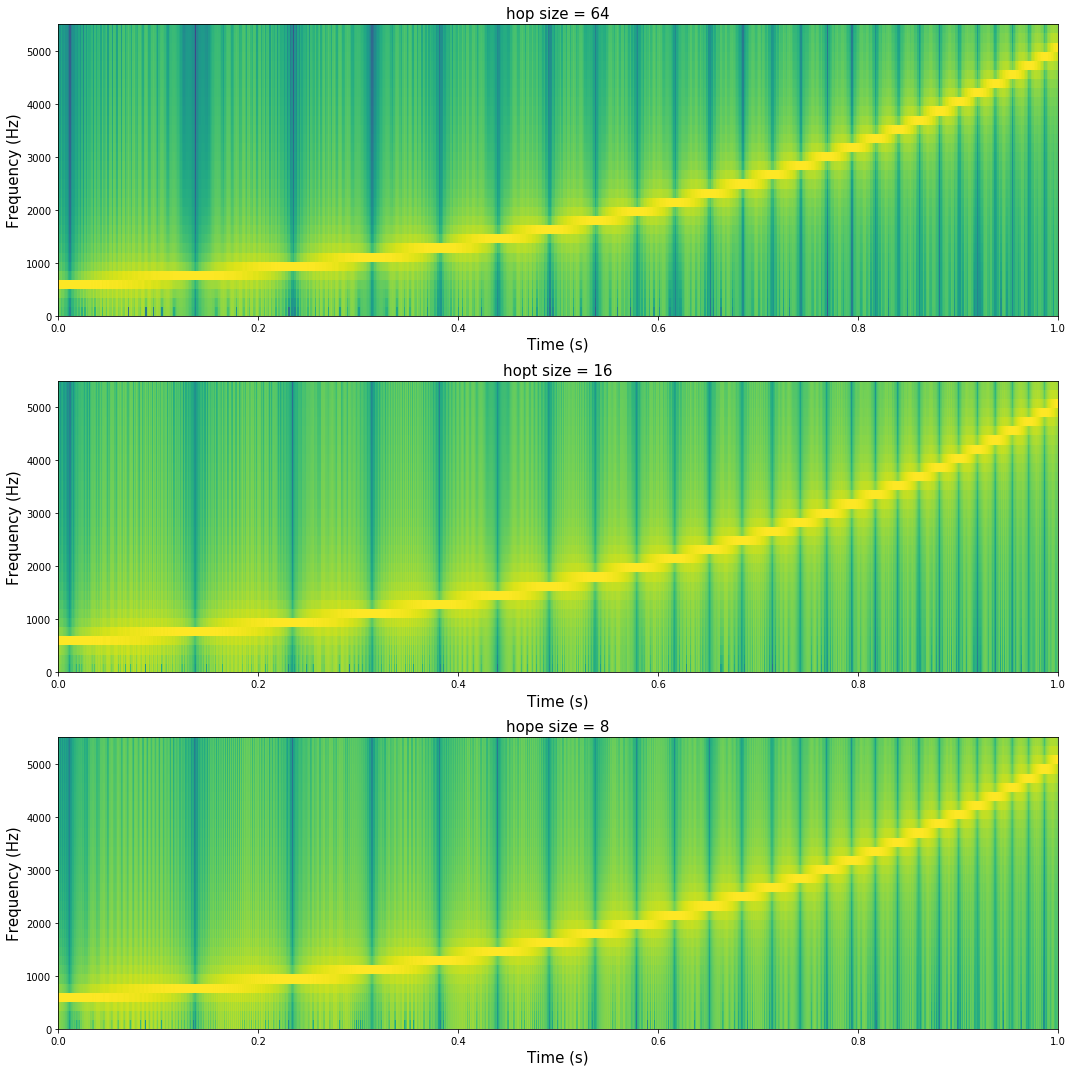

In [14]:
N = 256
plt.subplot(311)
plt.title('hop size = {}'.format(N // 4), fontsize = 15)
B1 = plot_spectrogram(x_sweep, window_size = N, hop_size = N // 4, window_type = 'boxcar', fs = 44100, nfft = N)
plt.subplot(312)
plt.title('hopt size = {}'.format(N // 16), fontsize = 15)
B2 = plot_spectrogram(x_sweep, window_size = N, hop_size = N // 16, window_type = 'boxcar', fs = 44100, nfft = N)
plt.subplot(313)
plt.title('hope size = {}'.format(N // 32), fontsize = 15)
B3 = plot_spectrogram(x_sweep, window_size = N, hop_size = N // 32, window_type = 'boxcar', fs = 44100, nfft = N)
plt.tight_layout()


`We see that decreasing the hop size adds time domain resolution, without changing the frequency domain resolution. This is because only the window size determines frequency resolution, not the hop size.`

**D. window types `triangular` and `hamming`**

(65, 688)
(65, 688)


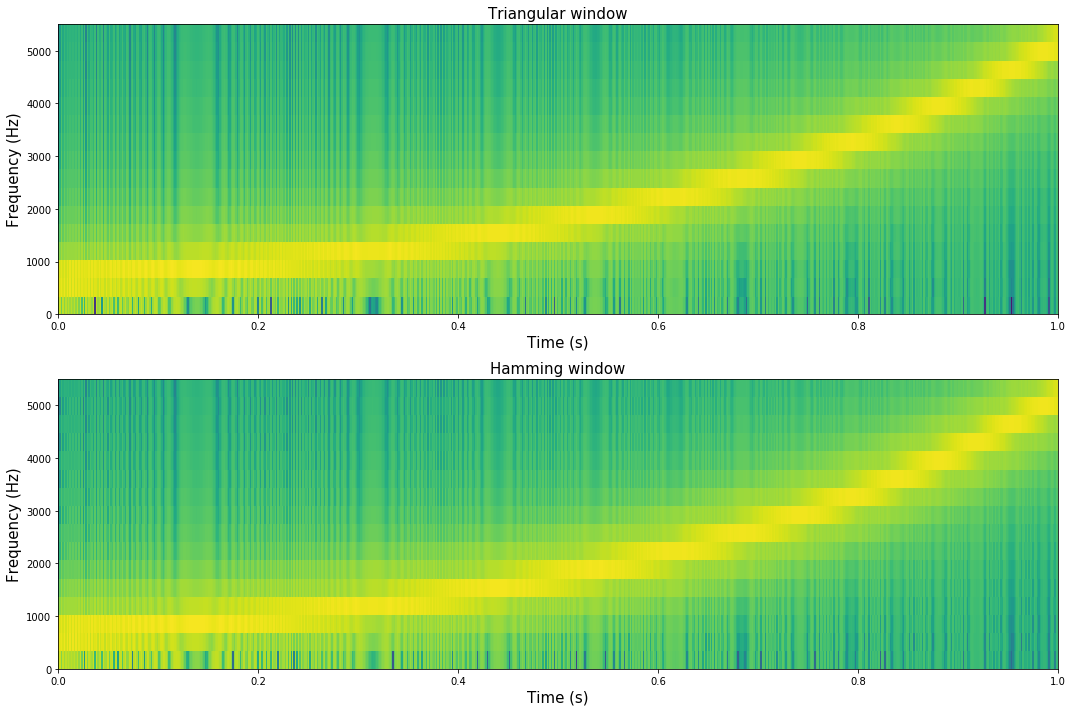

In [15]:
N = 128
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.title('Triangular window', fontsize = 15)
B1 = plot_spectrogram(x_sweep, window_size = N, hop_size = N // 2, window_type = 'triang', fs = 44100, nfft = N)
plt.subplot(212)
plt.title('Hamming window', fontsize = 15)
B2 = plot_spectrogram(x_sweep, window_size = N, hop_size = N // 2, window_type = 'hamm', fs = 44100, nfft = N)
plt.tight_layout()


`We see that spectral leakage is somewhat suppressed, when the input signal is windowed before fft conversion. This is because window functions have more attenuated sinc side lobes, as compared to a square boxcar function after fft. `

**E. window size `N=256`, fft length `2N`, `4N` and `8N`**

(257, 343)
(513, 343)
(1025, 343)


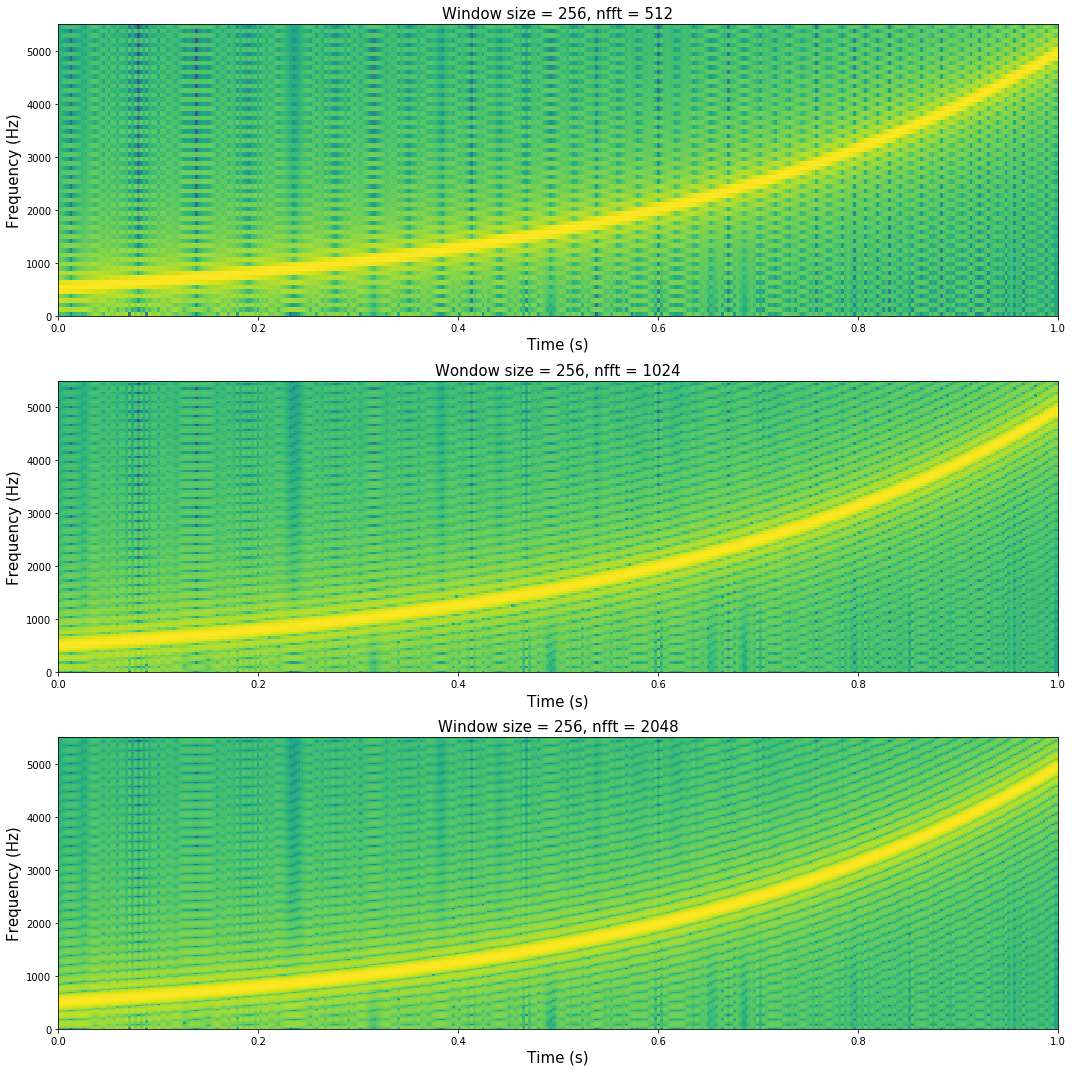

In [16]:
N = 256
plt.figure(figsize=(15,15))
plt.subplot(311)
plt.title('Window size = {}, nfft = {}'.format(N, 2*N), fontsize = 15)
B1 = plot_spectrogram(x_sweep, window_size = N, hop_size = N // 2, window_type = 'boxcar', fs = 44100, nfft = 2*N)
plt.subplot(312)
plt.title('Wondow size = {}, nfft = {}'.format(N, 4*N), fontsize = 15)
B2 = plot_spectrogram(x_sweep, window_size = N, hop_size = N // 2, window_type = 'boxcar', fs = 44100, nfft = 4*N)
plt.subplot(313)
plt.title('Window size = {}, nfft = {}'.format(N, 8*N), fontsize = 15)
B3 = plot_spectrogram(x_sweep, window_size = N, hop_size = N // 2, window_type = 'boxcar', fs = 44100, nfft = 8*N)
plt.tight_layout()


`We see the output graph looks clearer as we increase the nfft, without changing the window size. This is because by adding the nfft size, we are really zero-padding the fft samples. This interpolates the original windowed fft results, thus giving us the illusion of better resolution. No additional information about the frequency content is added, however. `